## ML

## Оценка точности модели, переобучение, регуляризация

Осуществить предсказание результатов спортивных соревнований 

### 1. Импорт библиотек / импорт и предобработка данных 

In [ ]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.metrics import roc_curve, roc_auc_score
import seaborn as sns
from matplotlib import pyplot as plt

In [ ]:
from sklearn import preprocessing
headers           = list(data2.iloc[:,[1,2]].columns.values)
min_max_scaler    = preprocessing.MinMaxScaler(feature_range=(-1,1))
data_scaled       = min_max_scaler.fit_transform(data2.iloc[:,[1,2]])
data_norm         = pd.DataFrame(data_scaled)
data_norm.columns = headers

data2 = data2.merge(data_norm, how = 'left', left_on = data.index, right_on=data_norm.index)


In [ ]:
data = pd.read_csv('athletes.csv')
data.head()

,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze
0,736041664,A Jesus Garcia,ESP,male,10/17/69,1.72,64.0,athletics,0,0,0
1,532037425,A Lam Shin,KOR,female,9/23/86,1.68,56.0,fencing,0,0,0
2,435962603,Aaron Brown,CAN,male,5/27/92,1.98,79.0,athletics,0,0,1
3,521041435,Aaron Cook,MDA,male,1/2/91,1.83,80.0,taekwondo,0,0,0
4,33922579,Aaron Gate,NZL,male,11/26/90,1.81,71.0,cycling,0,0,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11538 entries, 0 to 11537
Data columns (total 11 columns):
id             11538 non-null int64
name           11538 non-null object
nationality    11538 non-null object
sex            11538 non-null object
dob            11537 non-null object
height         11208 non-null float64
weight         10879 non-null float64
sport          11538 non-null object
gold           11538 non-null int64
silver         11538 non-null int64
bronze         11538 non-null int64
dtypes: float64(2), int64(4), object(5)
memory usage: 991.7+ KB


Посмотрим много ли в наших признаках пустых значений

In [ ]:
print('Для height пустых строк ' + str( len( data[ pd.isnull( data['height'] ) ] ) ))
print('Для weight пустых строк ' + str( len( data[ pd.isnull( data['weight'] ) ] ) ))
print('Для dob пустых строк ' + str( len( data[ pd.isnull( data['dob'] ) ] ) ))
print('Всего строк в наборе ' + str( len( data ) ))

Для height пустых строк 330
Для weight пустых строк 659
Для dob пустых строк 1
Всего строк в наборе 11538


In [ ]:
data[data.dob.isna()]

,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze
8546,663676373,Pavel Sozykin,RUS,male,NaN,NaN,NaN,sailing,0,0,0


По одному из наблюдений нет никаких наблюдений - посчитаем за выброс и удалим


In [ ]:
data = data[~data.dob.isna()]

### 2. Feature Engineering

#### 2.1. Страна и национальность 

In [ ]:
data['nationality'].value_counts().tail(), data['nationality'].value_counts().shape

(LBR    2
 GEQ    2
 NRU    2
 BHU    2
 TUV    1
 Name: nationality, dtype: int64, (207,))

Итого спортсмены из 207 стран / национальностей ... Попробуем раскодировать и сгруппировать по доступным кодировкам стран

In [ ]:
# Страны отмеченные по коду Alpha3
Countries = pd.read_html('https://www.artlebedev.ru/country-list/', encoding = 'utf-8')[0]
Countries_groups = Countries.groupby(['Alpha3'])['На английском', 'Часть света', 'Расположение'].max()

data = data.merge(Countries_groups, how = 'left', left_on='nationality', right_on='Alpha3')
data

,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze,На английском,Часть света,Расположение
0,736041664,A Jesus Garcia,ESP,male,10/17/69,1.72,64.0,athletics,0,0,0,Spain,Европа,Южная Европа
1,532037425,A Lam Shin,KOR,female,9/23/86,1.68,56.0,fencing,0,0,0,"Korea, Republic of",Азия,Восточная Азия
2,435962603,Aaron Brown,CAN,male,5/27/92,1.98,79.0,athletics,0,0,1,Canada,Америка,Северная Америка
3,521041435,Aaron Cook,MDA,male,1/2/91,1.83,80.0,taekwondo,0,0,0,Moldova,Европа,Восточная Европа
4,33922579,Aaron Gate,NZL,male,11/26/90,1.81,71.0,cycling,0,0,0,New Zealand,Океания,Австралия и Новая Зеландия
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11532,265605954,Zurian Hechavarria,CUB,female,8/10/95,1.64,58.0,athletics,0,0,0,Cuba,Америка,Карибский бассейн
11533,214461847,Zuzana Hejnova,CZE,female,12/19/86,1.73,63.0,athletics,0,0,0,Czech Republic,Европа,Восточная Европа
11534,88361042,di Xiao,CHN,male,5/14/91,1.85,100.0,wrestling,0,0,0,China,Азия,Восточная Азия
11535,900065925,le Quoc Toan Tran,VIE,male,4/5/89,1.60,56.0,weightlifting,0,0,0,NaN,NaN,NaN


In [ ]:
data[data['Расположение'].isna()].nationality.value_counts()

GER    441
NED    249
RSA    146
DEN    128
SUI    104
      ... 
BIZ      3
GEQ      2
MTN      2
BHU      2
CHA      2
Name: nationality, Length: 87, dtype: int64

87 стран выпали из кодировки ISO Alpha3, попробуем другие стандарты кодировок, например

In [ ]:
# Страны отмеченные по коду IOC
Countries2 = pd.read_html('http://www.statoids.com/wab.html', encoding = 'utf-8')[0]
Countries2_groups = Countries2.groupby(['IOC'])['249 countries'].max()
Countries2_groups

data = data.merge(Countries2_groups, how = 'left', left_on='nationality', right_on='IOC')
data.head()

,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze,На английском,Часть света,Расположение,249 countries
0,736041664,A Jesus Garcia,ESP,male,10/17/69,1.72,64.0,athletics,0,0,0,Spain,Европа,Южная Европа,Spain
1,532037425,A Lam Shin,KOR,female,9/23/86,1.68,56.0,fencing,0,0,0,"Korea, Republic of",Азия,Восточная Азия,"Korea, South"
2,435962603,Aaron Brown,CAN,male,5/27/92,1.98,79.0,athletics,0,0,1,Canada,Америка,Северная Америка,Canada
3,521041435,Aaron Cook,MDA,male,1/2/91,1.83,80.0,taekwondo,0,0,0,Moldova,Европа,Восточная Европа,Moldova
4,33922579,Aaron Gate,NZL,male,11/26/90,1.81,71.0,cycling,0,0,0,New Zealand,Океания,Австралия и Новая Зеландия,New Zealand


In [ ]:
data.rename(columns = {'На английском': 'Country', 
                       'Часть света'  : 'Geotype_big', 
                       'Расположение' : 'Geotype_small', 
                       '249 countries': 'Country_2'}, 
                        inplace = True) 
data.head(1)

,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze,Country,Geotype_big,Geotype_small,Country_2
0,736041664,A Jesus Garcia,ESP,male,10/17/69,1.72,64.0,athletics,0,0,0,Spain,Европа,Южная Европа,Spain


In [ ]:
data[(data['Geotype_small'].isna())&(data['Country_2'].isna())].nationality.value_counts()

ROT    10
IOA     9
KOS     8
Name: nationality, dtype: int64

In [ ]:
data.loc[data.Country.isna(), 'Country'] = data['Country_2']
data.loc[data.Country.isna()].nationality.value_counts()  #  ROT = 10, IOA = 9, KOS = 8

#  Может быть недостающие коды nationality - это коды аэропортов, из которых прилетели спортсмены 
# https://proaeroporty.ru/airports/aeroporty-iata-s  |  по справочнику IATA

data.loc[data.nationality == 'ROT', 'Country'] = 'New Zealand'
data.loc[data.nationality == 'IOA', 'Country'] = 'Greece'
data.loc[data.nationality == 'KOS', 'Country'] = 'Cambodja'

Объединим информацию о происхождении спортсменов из всех доступных источников

In [ ]:
data = data.merge(Countries_groups, how = 'left', left_on='Country', right_on='На английском')

In [ ]:
data.loc[data.Geotype_small.isna()].head()

,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze,Country,Geotype_big,Geotype_small,Country_2,На английском,Часть света,Расположение
12,258556239,Abbas Qali,IOA,male,10/11/92,NaN,NaN,aquatics,0,0,0,Greece,NaN,NaN,NaN,Greece,Европа,Южная Европа
17,256673338,Abbubaker Mobara,RSA,male,2/18/94,1.75,64.0,football,0,0,0,South Africa,NaN,NaN,South Africa,South Africa,Африка,Южная часть Африки
22,924593601,Abdalla Targan,SUD,male,9/28/96,1.77,65.0,athletics,0,0,0,Sudan,NaN,NaN,Sudan,Sudan,Африка,Северная Африка
26,189931373,Abdelaziz Mohamed Ahmed,SUD,male,10/12/94,1.81,72.0,aquatics,0,0,0,Sudan,NaN,NaN,Sudan,Sudan,Африка,Северная Африка
27,677622742,Abdelghani Demmou,ALG,male,1/29/89,1.85,75.0,football,0,0,0,Algeria,NaN,NaN,Algeria,Algeria,Африка,Северная Африка


In [ ]:
data.loc[data.Geotype_big.isna(),   'Geotype_big']   = data['Часть света']
data.loc[data.Geotype_small.isna(), 'Geotype_small'] = data['Расположение']

In [ ]:
data.loc[data.Geotype_small.isna()].Country.value_counts()

Iran                               64
Taiwan                             56
Congo (Brazzaville)                10
Cambodja                            8
Libya                               7
Tanzania                            7
Myanmar                             7
Palestine                           6
Saint Vincent and theGrenadines     4
Name: Country, dtype: int64

In [ ]:
b = data.loc[data.Geotype_small.isna()].Country.value_counts().index
c = ['Азия','Азия','Африка','Африка', 'Африка', 'Азия', 'Африка','Азия','Америка']
d = ['Западная Азия','Восточная Азия','Центральная Африка', 'Юго-Восточная Африка', 'Восточная Африка',
     'Юго-Восточная Азия', 'Северная Африка', 'Западная Азия', 'Карибский бассейн']

Contries_dop = pd.DataFrame(list(zip(b,c,d)), columns = Countries_groups.columns)

Countries_groups = pd.concat([Countries_groups, 
                              pd.DataFrame(list(zip(b,c,d)), columns = Countries_groups.columns) ]) 
Countries_groups.tail()

,На английском,Часть света,Расположение
4,Libya,Африка,Восточная Африка
5,Tanzania,Азия,Юго-Восточная Азия
6,Myanmar,Африка,Северная Африка
7,Palestine,Азия,Западная Азия
8,Saint Vincent and theGrenadines,Америка,Карибский бассейн


In [ ]:
data = data.merge(Countries_groups, how = 'left', left_on='Country', right_on='На английском')
data.head(1)

,id,name,nationality,sex,dob,height,weight,sport,gold,silver,...,Country,Geotype_big,Geotype_small,Country_2,На английском_x,Часть света_x,Расположение_x,На английском_y,Часть света_y,Расположение_y
0,736041664,A Jesus Garcia,ESP,male,10/17/69,1.72,64.0,athletics,0,0,...,Spain,Европа,Южная Европа,Spain,Spain,Европа,Южная Европа,Spain,Европа,Южная Европа


In [ ]:
data.loc[data.Geotype_big.isna(),   'Geotype_big']   = data['Часть света_y']
data.loc[data.Geotype_small.isna(), 'Geotype_small'] = data['Расположение_y']

In [ ]:
data = data.iloc[:,3:14]

In [ ]:
data.Geotype_big.value_counts()

Европа     4901
Америка    2610
Азия       2219
Африка     1035
Океания     772
Name: Geotype_big, dtype: int64

In [ ]:
data.Geotype_small.value_counts()

Западная Европа                 1399
Восточная Европа                1336
Южная Европа                    1151
Восточная Азия                  1131
Южная Америка                   1111
Северная Европа                 1015
Северная Америка                 896
Австралия и Новая Зеландия       649
Западная Азия                    484
Карибский бассейн                392
Южная часть Центральной Азии     370
Северная Африка                  316
Восточная Африка                 267
Юго-Восточная Азия               234
Центральная Америка              211
Западная Африка                  183
Южная часть Африки               178
Центральная Африка                83
Меланезия                         69
Полинезия                         29
Микронезия                        25
Юго-Восточная Африка               8
Name: Geotype_small, dtype: int64

In [ ]:
data[data.Geotype_big == 'Океания'].Geotype_small.value_counts()  
data[data.Geotype_big == 'Африка'].Geotype_small.value_counts()  
data.loc[(data.Geotype_small == 'Южная часть Африки'),   'Geotype_small'] = 'Южная Африка'
data.loc[(data.Geotype_small == 'Центральная Африка'),   'Geotype_small'] = 'Южная Африка'
data.loc[(data.Geotype_small == 'Юго-Восточная Африка'), 'Geotype_small'] = 'Южная Африка'

data.loc[(data.Geotype_big   == 'Океания'),               'Geotype_small'] = 'Австралия и Океания'       
        
data.Geotype_small.value_counts()     

Западная Европа                 1399
Восточная Европа                1336
Южная Европа                    1151
Восточная Азия                  1131
Южная Америка                   1111
Северная Европа                 1015
Северная Америка                 896
Австралия и Океания              772
Западная Азия                    484
Карибский бассейн                392
Южная часть Центральной Азии     370
Северная Африка                  316
Южная Африка                     269
Восточная Африка                 267
Юго-Восточная Азия               234
Центральная Америка              211
Западная Африка                  183
Name: Geotype_small, dtype: int64

#### 2.2. Виды спорта

In [ ]:
data['sport'].value_counts().head(), data['sport'].value_counts().shape

(athletics    2363
 aquatics     1445
 football      611
 rowing        547
 cycling       525
 Name: sport, dtype: int64, (28,))

Обычные виды спорта ничего не буду менять

#### 2.3. Возраст / год рождения

In [ ]:
data['age_type']  = pd.cut(pd.to_datetime(data.dob).dt.year, 
                           [0, 1985, 1990, 1995, 29999], 
                           include_lowest=True)

In [ ]:
data['age_type'].value_counts()

(1990.0, 1995.0]     4157
(1985.0, 1990.0]     3965
(-0.001, 1985.0]     2254
(1995.0, 29999.0]    1161
Name: age_type, dtype: int64

#### 2.4. Рост и вес

предсказываем рост виду спорта и части света происхождения спортсмена / медиана

In [ ]:
h1 = data.groupby(['sport', 'Geotype_big']).height.median()
data1 = pd.merge(data, h1, how ='left', on = ['sport', 'Geotype_big']) 
data1

,sex,dob,height_x,weight,sport,gold,silver,bronze,Country,Geotype_big,Geotype_small,age_type,height_y
0,male,10/17/69,1.72,64.0,athletics,0,0,0,Spain,Европа,Южная Европа,"(1995.0, 29999.0]",1.770
1,female,9/23/86,1.68,56.0,fencing,0,0,0,"Korea, Republic of",Азия,Восточная Азия,"(1985.0, 1990.0]",1.760
2,male,5/27/92,1.98,79.0,athletics,0,0,1,Canada,Америка,Северная Америка,"(1990.0, 1995.0]",1.750
3,male,1/2/91,1.83,80.0,taekwondo,0,0,0,Moldova,Европа,Восточная Европа,"(1990.0, 1995.0]",1.785
4,male,11/26/90,1.81,71.0,cycling,0,0,0,New Zealand,Океания,Австралия и Океания,"(1985.0, 1990.0]",1.770
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11532,female,8/10/95,1.64,58.0,athletics,0,0,0,Cuba,Америка,Карибский бассейн,"(1990.0, 1995.0]",1.750
11533,female,12/19/86,1.73,63.0,athletics,0,0,0,Czech Republic,Европа,Восточная Европа,"(1985.0, 1990.0]",1.770
11534,male,5/14/91,1.85,100.0,wrestling,0,0,0,China,Азия,Восточная Азия,"(1990.0, 1995.0]",1.700
11535,male,4/5/89,1.60,56.0,weightlifting,0,0,0,Vietnam,Азия,Юго-Восточная Азия,"(1985.0, 1990.0]",1.635


In [ ]:
from sklearn.metrics import mean_squared_error 

Yh_true = data1[data1.height_x >0].height_x
Yh_pred = data1[data1.height_x >0].height_y

mean_squared_error(Yh_true,Yh_pred)

0.009490216809421841

In [ ]:
data1.loc[data1.height_x.isna(), 'height_x'] = data1.height_y
data1 = data1.iloc[:,[0,2,3,4,5,6,7,8,9,10,11]]
data1.head(1)

,sex,height_x,weight,sport,gold,silver,bronze,Country,Geotype_big,Geotype_small,age_type
0,male,1.72,64.0,athletics,0,0,0,Spain,Европа,Южная Европа,"(1995.0, 29999.0]"


In [ ]:
data1['heigh_type']  = pd.cut(data1.height_x, 
                              [0, 1.6, 1.7, 1.8, 1.9, 2.0, 3.00], 
                               include_lowest=True)

C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
data1['heigh_type'].value_counts()

(1.7, 1.8]       3976
(1.6, 1.7]       2805
(1.8, 1.9]       2683
(1.9, 2.0]       1045
(-0.001, 1.6]     801
(2.0, 3.0]        227
Name: heigh_type, dtype: int64

Предсказываем вес по медиане  .... 

In [ ]:
params = ['Geotype_small', 'sport', 'heigh_type']
w1    = data1.groupby(params).weight.median()
data2 = pd.merge(data1, w1, how ='left', on = params) 
data2.head()

,sex,height_x,weight_x,sport,gold,silver,bronze,Country,Geotype_big,Geotype_small,age_type,heigh_type,weight_y
0,male,1.72,64.0,athletics,0,0,0,Spain,Европа,Южная Европа,"(1995.0, 29999.0]","(1.7, 1.8]",63.0
1,female,1.68,56.0,fencing,0,0,0,"Korea, Republic of",Азия,Восточная Азия,"(1985.0, 1990.0]","(1.6, 1.7]",59.0
2,male,1.98,79.0,athletics,0,0,1,Canada,Америка,Северная Америка,"(1990.0, 1995.0]","(1.9, 2.0]",88.0
3,male,1.83,80.0,taekwondo,0,0,0,Moldova,Европа,Восточная Европа,"(1990.0, 1995.0]","(1.8, 1.9]",80.0
4,male,1.81,71.0,cycling,0,0,0,New Zealand,Океания,Австралия и Океания,"(1985.0, 1990.0]","(1.8, 1.9]",77.5


In [ ]:
data2.loc[data2.weight_x.isna(), 'weight_x'] = data2.weight_y

In [ ]:
data2.loc[data2.weight_x.isna()].sport.value_counts()

boxing       286
badminton      2
rowing         1
golf           1
judo           1
Name: sport, dtype: int64

In [ ]:
params = ['Geotype_small', 'heigh_type']
w2    = data2.groupby(params).weight_x.median()
data2 = pd.merge(data2, w2, how ='left', on = params) 
data2.head()

,sex,height_x,weight_x_x,sport,gold,silver,bronze,Country,Geotype_big,Geotype_small,age_type,heigh_type,weight_y,weight_x_y
0,male,1.72,64.0,athletics,0,0,0,Spain,Европа,Южная Европа,"(1995.0, 29999.0]","(1.7, 1.8]",63.0,69.0
1,female,1.68,56.0,fencing,0,0,0,"Korea, Republic of",Азия,Восточная Азия,"(1985.0, 1990.0]","(1.6, 1.7]",59.0,59.0
2,male,1.98,79.0,athletics,0,0,1,Canada,Америка,Северная Америка,"(1990.0, 1995.0]","(1.9, 2.0]",88.0,88.0
3,male,1.83,80.0,taekwondo,0,0,0,Moldova,Европа,Восточная Европа,"(1990.0, 1995.0]","(1.8, 1.9]",80.0,80.0
4,male,1.81,71.0,cycling,0,0,0,New Zealand,Океания,Австралия и Океания,"(1985.0, 1990.0]","(1.8, 1.9]",77.5,81.0


In [ ]:
data2.loc[data2.weight_x_x.isna(), 'weight_x_x'] = data2.weight_x_y

### 3. Нормализация данных 


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.metrics import roc_curve, roc_auc_score
from matplotlib import pyplot as plt

In [ ]:
data2 = data2.iloc[:,[1,4,5,6,7,8,9,10,11,15,16]]
data2

,sex,sport,gold,silver,bronze,Country,Geotype_big,Geotype_small,age_type,height_x_y,weight_x_x_y
0,male,athletics,0,0,0,Spain,Европа,Южная Европа,"(1995.0, 29999.0]",0.02,-0.525180
1,female,fencing,0,0,0,"Korea, Republic of",Азия,Восточная Азия,"(1985.0, 1990.0]",-0.06,-0.640288
2,male,athletics,0,0,1,Canada,Америка,Северная Америка,"(1990.0, 1995.0]",0.54,-0.309353
3,male,taekwondo,0,0,0,Moldova,Европа,Восточная Европа,"(1990.0, 1995.0]",0.24,-0.294964
4,male,cycling,0,0,0,New Zealand,Океания,Австралия и Океания,"(1985.0, 1990.0]",0.20,-0.424460
...,...,...,...,...,...,...,...,...,...,...,...
11532,female,athletics,0,0,0,Cuba,Америка,Карибский бассейн,"(1990.0, 1995.0]",-0.14,-0.611511
11533,female,athletics,0,0,0,Czech Republic,Европа,Восточная Европа,"(1985.0, 1990.0]",0.04,-0.539568
11534,male,wrestling,0,0,0,China,Азия,Восточная Азия,"(1990.0, 1995.0]",0.28,-0.007194
11535,male,weightlifting,0,0,0,Vietnam,Азия,Юго-Восточная Азия,"(1985.0, 1990.0]",-0.22,-0.640288


(5.0, 0.0)

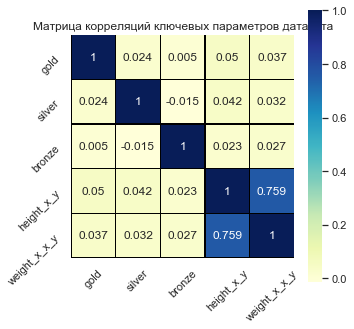

In [ ]:
sns.set(rc={'figure.figsize':(5,5)})
ax = sns.heatmap(data2.corr().round(3),  
                annot = True, 
                fmt='.3g', 
                cmap= 'YlGnBu', 
                linewidths=0.1, 
                linecolor='black', 
                square=True)

plt.title('Матрица корреляций ключевых параметров датасета')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5)

Не могу объяснить корелляцию между ростом и весом,  интуитивно - так не может быть ... или это выборка по видам спорта особенная


### 4. Построение модели

#### 4.1. Логистическая регрессия

In [ ]:
X          = pd.get_dummies(data=data2.iloc[:,[1,5,9,10]], columns=['sport', 'Country'])
y          = data2['sex']

le         = LabelEncoder()
ohe        = OneHotEncoder()
le.fit(      data2['sex'])
y          = pd.Series( data = le.transform( data['sex'] ) )
model      = LogisticRegression(max_iter=100000)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10000)
model.fit(X_train, y_train)

predictions     = model.predict_proba(X_test)[:, 1]
fpr, tpr, thres = roc_curve( y_test, predictions)

In [ ]:
# Точность модели
model.score(X, y)

0.83487908468406

#### 4.2. Метрики качества модели

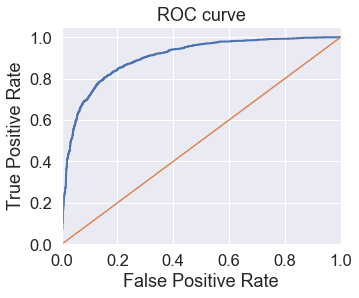

In [ ]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(5, 4))
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1], pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

In [ ]:
roc_auc_score(y_test, predictions)

0.9015858812585942

In [ ]:
roc_auc_score(y_test, model.predict(X_test))

0.8219172126506512

In [ ]:
tp = 0 # True positive
fp = 0 # False positive
fn = 0 # False negative
tn = 0 # True negative

predictions = model.predict_proba( X_test )
for predicted_prob, actual in zip( predictions[:, 1], y_test ):    
    if predicted_prob >= 0.5:
        predicted = 1
    else:
        predicted = 0
    
    if predicted == 1:
        if actual == 1:
            tp += 1
        else:
            fp += 1
    
    else:
        if actual == 1:
            fn += 1
        else:
            tn += 1

# Расчетная точность модели
(tp + tn) / (tp + fp + fn + tn)

0.8235124205661467

Populating the interactive namespace from numpy and matplotlib


Text(0, 0.5, 'precision')

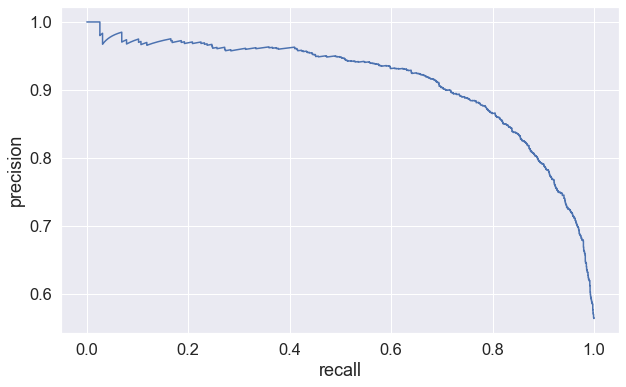

In [ ]:
from sklearn.metrics import precision_recall_curve
%pylab inline

pr, rec, thres = precision_recall_curve( y_test, predictions[:, 1] )

plt.figure(figsize=(10, 6))
plt.plot( rec, pr )
plt.xlabel('recall')
plt.ylabel('precision')

In [ ]:
from sklearn.metrics import average_precision_score
average_precision_score( y_test, predictions[:, 1] )

0.9125713384559438

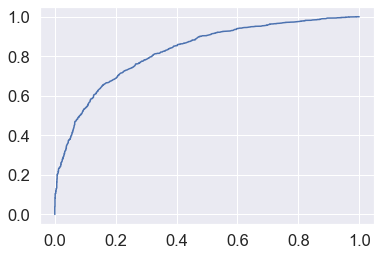

In [ ]:
# ROC-кривая (Receiver Operating Characteristic)
from sklearn.metrics import roc_curve

# получаем значения false и true positive rate для различных значений порога
fpr, tpr, thres = roc_curve( y_test, predictions[:, 1] )
    
plt.plot( fpr, tpr )
plt.show()

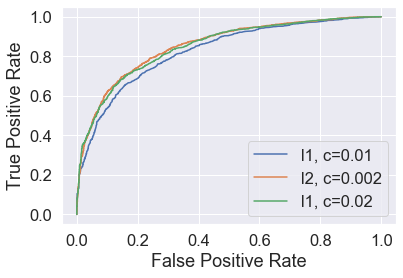

In [ ]:
# Влияние L1 и L2-регуляризации

model1 = LogisticRegression( penalty = 'l1', C = 0.01, solver='liblinear' ).fit( X_train, y_train )
predictions = model1.predict_proba( X_test )

model2 = LogisticRegression(  C = 0.002 ).fit( X_train, y_train )
predictions2 = model2.predict_proba( X_test )

model3 = LogisticRegression( penalty = 'l1', C = 0.02, solver='liblinear' ).fit( X_train, y_train )
predictions3 = model3.predict_proba( X_test )

fpr, tpr, thres    = roc_curve( y_test, predictions[:, 1] )
fpr2, tpr2, thres2 = roc_curve( y_test, predictions2[:, 1] )
fpr3, tpr3, thres3 = roc_curve( y_test, predictions3[:, 1] )

plt.plot( fpr, tpr, label   = 'l1, c=0.01' )
plt.plot( fpr2, tpr2, label = 'l2, c=0.002' )
plt.plot( fpr3, tpr3, label = 'l1, c=0.02')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend( loc = 0 )
plt.show()
